In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lshash import LSHash
from math import radians, cos, sin, asin, sqrt
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def input():

    # file input
    data = pd.read_csv('data_2g.csv', index_col=None)
    gongcan = pd.read_csv('2g_gongcan.csv', index_col=None)

    # data merge
    for i in range(1, 8):
        gongcan_temp = gongcan.rename(columns={'RNCID': 'RNCID_' + str(i),'CellID': 'CellID_' + str(i),'Latitude': 'Latitude_' + str(i),'Longitude': 'Longitude_' + str(i)})
        data = pd.merge(data, gongcan_temp, how='left', on=['RNCID_' + str(i), 'CellID_' + str(i)])
        
    return data


def classify(data):

    # get the area
    lat = haversine(121.20120490000001, 31.28175691, 121.20120490000001, 31.29339344)*1000
    lon = haversine(121.20120490000001, 31.28175691, 121.2183295, 31.28175691)*1000
    width = 20

    # create Grid ID
    lon_grid = int(lon/width)
    lon_width = (121.2183295-121.20120490000001)/lon_grid
    lat_grid = int(lat/width)
    lat_width = (31.29339344-31.28175691)/lat_grid

    # transfer Longitude,Latitude into Grid ID
    data['lon_grid'] = (data['Longitude']-121.20120490000001)/lon_width
    data['lat_grid'] = (data['Latitude']-31.28175691)/lat_width
    data['lon_grid'] = data['lon_grid'].apply(int)
    data['lat_grid'] = data['lat_grid'].apply(int)
    data['grid'] = data['lon_grid'] + data['lat_grid']*lon_grid

    return data


def reverse(result):

    # get the area
    lat = haversine(121.20120490000001, 31.28175691, 121.20120490000001, 31.29339344)*1000
    lon = haversine(121.20120490000001, 31.28175691, 121.2183295, 31.28175691)*1000
    width = 20

    # create Grid ID
    lon_grid = int(lon/width)
    lon_width = (121.2183295-121.20120490000001)/lon_grid
    lat_grid = int(lat/width)
    lat_width = (31.29339344-31.28175691)/lat_grid

    # transfer Grid ID into Longitude,Latitude
    result['lat_grid'] = result['grid']/lon_grid
    result['lat_grid'] = result['lat_grid'].apply(int)
    result['lon_grid'] = result['grid'] - result['lat_grid']*lon_grid
    result['Longitude_pred'] = (result['lon_grid']+0.5)*lon_width+121.20120490000001
    result['Latitude_pred'] = (result['lat_grid']+0.5)*lat_width+31.28175691

    return result.drop(['lat_grid','lon_grid'], axis=1)


def evaluate(test_set, result_set):

    # calculate the abs range
    compare_set = pd.concat([test_set.reset_index(drop=True), result_set.reset_index(drop=True)], axis=1, ignore_index=True)
    compare_set['lon_dev'] = abs(compare_set[0] - compare_set[3])
    compare_set['lat_dev'] = abs(compare_set[1] - compare_set[4])
    
    # calculate the deviation
    compare_set['error'] = compare_set['lon_dev'] + compare_set['lat_dev']
    compare_set = compare_set.sort_values(['error'])

    # get point
    deviation = [0]
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        deviation.append(haversine(compare_set.iloc[int(i*compare_set.shape[0]), ]['error'],0,0,0)*1000)

    return deviation


def createInitSet(data):

    # create training set
    training_set = data.sample(frac=0.8)
    training_labels = training_set['grid']
    training_features = training_set.drop(['IMSI','MRTime','Longitude','Latitude','Num_connected','lon_grid','lat_grid','grid','RNCID_1','CellID_1','RNCID_2','CellID_2','RNCID_3','CellID_3','RNCID_4','CellID_4','RNCID_5','CellID_5','RNCID_6','CellID_6','RNCID_7','CellID_7'], axis=1).fillna(0)

    # create test set
    test_set = data.append(training_set).drop_duplicates(keep=False)
    test_labels = test_set['grid'].values
    test_pos = pd.DataFrame()
    test_pos['Longitude'] = test_set['Longitude']
    test_pos['Latitude'] = test_set['Latitude']
    test_features = test_set.drop(['IMSI','MRTime','Longitude','Latitude','Num_connected','lon_grid','lat_grid','grid','RNCID_1','CellID_1','RNCID_2','CellID_2','RNCID_3','CellID_3','RNCID_4','CellID_4','RNCID_5','CellID_5','RNCID_6','CellID_6','RNCID_7','CellID_7'], axis=1).fillna(0)

    return training_features, test_features, training_labels, test_labels, test_pos



D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning

GaussianNB report:
             precision    recall  f1-score   support

         50       0.00      0.00      0.00         2
         51       0.00      0.00      0.00         2
         52       0.00      0.00      0.00         4
         53       0.00      0.00      0.00         1
         54       0.00      0.00      0.00         2
         55       0.00      0.00      0.00         2
         56       0.00      0.00      0.00         2
         57       0.00      0.00      0.00         1
         58       0.00      0.00      0.00         1
         59       0.00      0.00      0.00         2
         60       0.00      0.00      0.00         3
         61       0.00      0.00      0.00         2
         62       0.00      0.00      0.00         2
         63       0.25      0.33      0.29         3
         64       0.00      0.00      0.00         1
        128       0.00      0.00      0.00         1
        129       0.00      0.00      0.00         2
        130       0.00    

KNeighborsClassifier report:
             precision    recall  f1-score   support

         50       0.25      0.50      0.33         2
         51       0.33      1.00      0.50         2
         52       0.00      0.00      0.00         4
         53       0.00      0.00      0.00         1
         54       0.00      0.00      0.00         2
         55       0.50      0.50      0.50         2
         56       0.00      0.00      0.00         2
         57       0.33      1.00      0.50         1
         58       0.00      0.00      0.00         1
         59       0.50      0.50      0.50         2
         60       1.00      0.67      0.80         3
         61       0.00      0.00      0.00         2
         62       0.00      0.00      0.00         2
         63       0.25      0.33      0.29         3
         64       0.00      0.00      0.00         1
        128       0.00      0.00      0.00         1
        129       0.11      0.50      0.18         2
        130     

DecisionTreeClassifier report:
             precision    recall  f1-score   support

         50       0.33      0.50      0.40         2
         51       0.33      1.00      0.50         2
         52       0.50      0.25      0.33         4
         53       0.00      0.00      0.00         1
         54       0.00      0.00      0.00         2
         55       0.40      1.00      0.57         2
         56       0.00      0.00      0.00         2
         57       0.50      1.00      0.67         1
         58       0.00      0.00      0.00         1
         59       0.33      0.50      0.40         2
         60       0.33      0.33      0.33         3
         61       0.00      0.00      0.00         2
         62       0.00      0.00      0.00         2
         63       1.00      0.33      0.50         3
         64       0.00      0.00      0.00         1
        128       0.00      0.00      0.00         1
        129       0.00      0.00      0.00         2
        130   

AdaBoost report:
             precision    recall  f1-score   support

         50       0.33      0.50      0.40         2
         51       0.33      1.00      0.50         2
         52       0.50      0.25      0.33         4
         53       0.00      0.00      0.00         1
         54       0.00      0.00      0.00         2
         55       0.40      1.00      0.57         2
         56       0.00      0.00      0.00         2
         57       0.50      1.00      0.67         1
         58       0.00      0.00      0.00         1
         59       0.33      0.50      0.40         2
         60       1.00      0.33      0.50         3
         61       0.50      1.00      0.67         2
         62       0.00      0.00      0.00         2
         63       1.00      0.33      0.50         3
         64       0.00      0.00      0.00         1
        128       0.00      0.00      0.00         1
        129       0.00      0.00      0.00         2
        130       0.50      

BaggingClassifier report:
             precision    recall  f1-score   support

         50       0.50      0.50      0.50         2
         51       0.33      1.00      0.50         2
         52       0.00      0.00      0.00         4
         53       0.00      0.00      0.00         1
         54       0.00      0.00      0.00         2
         55       0.00      0.00      0.00         2
         56       0.00      0.00      0.00         2
         57       0.50      1.00      0.67         1
         58       0.00      0.00      0.00         1
         59       0.50      0.50      0.50         2
         60       0.00      0.00      0.00         3
         61       0.00      0.00      0.00         2
         62       0.00      0.00      0.00         2
         63       0.33      0.33      0.33         3
         64       0.00      0.00      0.00         1
        128       0.00      0.00      0.00         1
        129       0.50      0.50      0.50         2
        130       0

GradientBoostingClassifier report:
             precision    recall  f1-score   support

         50       0.05      0.50      0.08         2
         51       0.00      0.00      0.00         2
         52       0.00      0.00      0.00         4
         53       0.00      0.00      0.00         1
         54       0.00      0.00      0.00         2
         55       0.00      0.00      0.00         2
         56       0.00      0.00      0.00         2
         57       0.00      0.00      0.00         1
         58       0.00      0.00      0.00         1
         59       0.00      0.00      0.00         2
         60       0.00      0.00      0.00         3
         61       0.00      0.00      0.00         2
         62       0.00      0.00      0.00         2
         63       0.00      0.00      0.00         3
         64       0.00      0.00      0.00         1
        128       0.00      0.00      0.00         1
        129       0.00      0.00      0.00         2
        13

RandomForestClassifier report:
             precision    recall  f1-score   support

         50       0.50      0.50      0.50         2
         51       0.33      1.00      0.50         2
         52       0.00      0.00      0.00         4
         53       0.00      0.00      0.00         1
         54       0.00      0.00      0.00         2
         55       0.50      1.00      0.67         2
         56       0.00      0.00      0.00         2
         57       0.50      1.00      0.67         1
         58       0.00      0.00      0.00         1
         59       0.20      0.50      0.29         2
         60       1.00      0.33      0.50         3
         61       0.00      0.00      0.00         2
         62       0.00      0.00      0.00         2
         63       0.33      0.33      0.33         3
         64       0.00      0.00      0.00         1
        128       0.00      0.00      0.00         1
        129       0.00      0.00      0.00         2
        130   

1
2
3
4
5
6
7
8
9


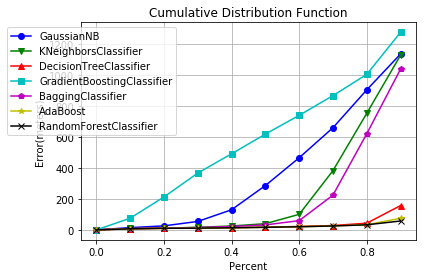

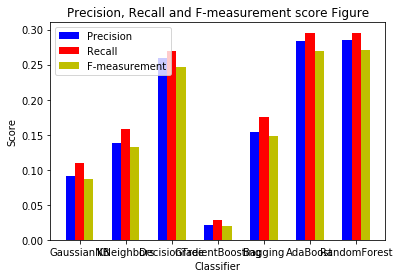

In [2]:
if __name__ == '__main__':

    # input
    data_set = input()
    data_set = classify(data_set)

    score_GaussianNB = []
    score_KNeighborsClassifier = []
    score_DecisionTreeClassifier = []
    score_GradientBoostingClassifier = []
    score_KNC_BC = []
    score_DTC_AB = []
    score_RandomForestClassifier = []

    # Precision
    P_GNB = []
    P_KNC = []
    P_DTC = []
    P_GBC = []
    P_BC = []
    P_ABC = []
    P_RFC = []

    # Recall
    R_GNB = []
    R_KNC = []
    R_DTC = []
    R_GBC = []
    R_BC = []
    R_ABC = []
    R_RFC = []

    # F-measurement
    F_GNB = []
    F_KNC = []
    F_DTC = []
    F_GBC = []
    F_BC = []
    F_ABC = []
    F_RFC = []

    for i in range(0, 10):
        # init data set
        training_set, test_set, training_labels, test_labels, test_pos = createInitSet(data_set)

        # GaussianNB
        # train
        clf = GaussianNB().fit(training_set, training_labels)

        # test
        pred = clf.predict(test_set)

        # transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

        # calculate the deviation
        deviation = evaluate(test_pos, result)
        score_GaussianNB.append(deviation)

        # Precision
        P_GNB.append(precision_score(test_labels, pred, average='macro'))

        # Recall
        R_GNB.append(recall_score(test_labels, pred, average='macro'))

        # F-measurement
        F_GNB.append(f1_score(test_labels, pred, average='macro'))
        
        # get report
        if i == 0:
            print 'GaussianNB report:\n', classification_report(test_labels, pred)

        # KNeighborsClassifier
        # train
        clf = KNeighborsClassifier().fit(training_set, training_labels)

        # test
        pred = clf.predict(test_set)

        # transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

        # calculate the deviation
        deviation = evaluate(test_pos, result)
        score_KNeighborsClassifier.append(deviation)

        # Precision
        P_KNC.append(precision_score(test_labels, pred, average='macro'))

        # Recall
        R_KNC.append(recall_score(test_labels, pred, average='macro'))

        # F-measurement
        F_KNC.append(f1_score(test_labels, pred, average='macro'))

        # get report
        if i == 0:
            print 'KNeighborsClassifier report:\n', classification_report(test_labels, pred)

        # DecisionTreeClassifier
        # train
        clf = DecisionTreeClassifier().fit(training_set, training_labels)

        # test
        pred = clf.predict(test_set)

        # transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

        # calculate the deviation
        deviation = evaluate(test_pos, result)
        score_DecisionTreeClassifier.append(deviation)

        # Precision
        P_DTC.append(precision_score(test_labels, pred, average='macro'))

        # Recall
        R_DTC.append(recall_score(test_labels, pred, average='macro'))

        # F-measurement
        F_DTC.append(f1_score(test_labels, pred, average='macro'))

        # get report
        if i == 0:
            print 'DecisionTreeClassifier report:\n', classification_report(test_labels, pred)

        # AdaBoost+DecisionTreeClassifier
        # train
        clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()).fit(training_set, training_labels)

        # test
        pred = clf.predict(test_set)

        # transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

        # calculate the deviation
        deviation = evaluate(test_pos, result)
        score_DTC_AB.append(deviation)

        # Precision
        P_ABC.append(precision_score(test_labels, pred, average='macro'))

        # Recall
        R_ABC.append(recall_score(test_labels, pred, average='macro'))

        # F-measurement
        F_ABC.append(f1_score(test_labels, pred, average='macro'))

        # get report
        if i == 0:
            print 'AdaBoost report:\n', classification_report(test_labels, pred)

        # BaggingClassifier+KNeighborsClassifier
        # train
        clf = BaggingClassifier(base_estimator=KNeighborsClassifier()).fit(training_set, training_labels)

        # test
        pred = clf.predict(test_set)

        # transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

        # calculate the deviation
        deviation = evaluate(test_pos, result)
        score_KNC_BC.append(deviation)

        # Precision
        P_BC.append(precision_score(test_labels, pred, average='macro'))

        # Recall
        R_BC.append(recall_score(test_labels, pred, average='macro'))

        # F-measurement
        F_BC.append(f1_score(test_labels, pred, average='macro'))

        # get report
        if i == 0:
            print 'BaggingClassifier report:\n', classification_report(test_labels, pred)

        # GradientBoostingClassifier
        # train
        clf = GradientBoostingClassifier(n_estimators=2).fit(training_set, training_labels)

        # test
        pred = clf.predict(test_set)

        # transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

        # calculate the deviation
        deviation = evaluate(test_pos, result)
        score_GradientBoostingClassifier.append(deviation)

        # Precision
        P_GBC.append(precision_score(test_labels, pred, average='macro'))

        # Recall
        R_GBC.append(recall_score(test_labels, pred, average='macro'))

        # F-measurement
        F_GBC.append(f1_score(test_labels, pred, average='macro'))

        # get report
        if i == 0:
            print 'GradientBoostingClassifier report:\n', classification_report(test_labels, pred)

        # RandomForestClassifier
        # train
        clf = RandomForestClassifier().fit(training_set, training_labels)

        # test
        pred = clf.predict(test_set)

        # transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

        # calculate the deviation
        deviation = evaluate(test_pos, result)
        score_RandomForestClassifier.append(deviation)

        # Precision
        P_RFC.append(precision_score(test_labels, pred, average='macro'))

        # Recall
        R_RFC.append(recall_score(test_labels, pred, average='macro'))

        # F-measurement
        F_RFC.append(f1_score(test_labels, pred, average='macro'))
        
        # get report
        if i == 0:
            print 'RandomForestClassifier report:\n', classification_report(test_labels, pred)
            
        print i

    error_set = []
    for score in [score_GaussianNB, score_KNeighborsClassifier, score_DecisionTreeClassifier, score_GradientBoostingClassifier, score_KNC_BC, score_DTC_AB, score_RandomForestClassifier]:
        score = pd.DataFrame(data=score)
        avr_score = []
        for i in range(0, 10):
            avr_score.append(score[i].mean())
        error_set.append(avr_score)

    precision_set = []
    for precision in [P_GNB, P_KNC, P_DTC, P_GBC, P_BC, P_ABC, P_RFC]:
        precision_set.append(sum(precision)/len(precision))

    recall_set = []
    for recall in [R_GNB, R_KNC, R_DTC, R_GBC, R_BC, R_ABC, R_RFC]:
        recall_set.append(sum(recall)/len(recall))
    
    f1_set = []
    for f1 in [F_GNB, F_KNC, F_DTC, F_GBC, F_BC, F_ABC, F_RFC]:
        f1_set.append(sum(f1)/len(f1))

    # draw the CDF figure
    group_labels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    plt.title('Cumulative Distribution Function')  
    plt.xlabel('Percent')  
    plt.ylabel('Error(meters)') 

    plt.plot(group_labels, error_set[0],'bo-', label='GaussianNB') 
    plt.plot(group_labels, error_set[1],'gv-', label='KNeighborsClassifier') 
    plt.plot(group_labels, error_set[2],'r^-', label='DecisionTreeClassifier') 
    plt.plot(group_labels, error_set[3],'cs-', label='GradientBoostingClassifier') 
    plt.plot(group_labels, error_set[4],'mp-', label='BaggingClassifier') 
    plt.plot(group_labels, error_set[5],'y*-', label='AdaBoost') 
    plt.plot(group_labels, error_set[6],'kx-', label='RandomForestClassifier') 
    
    plt.legend(bbox_to_anchor=[0.3, 1])  
    plt.grid()  
    plt.show()

    # draw the score figure
    plt.title('Precision, Recall and F-measurement score Figure')  
    plt.xlabel('Classifier')  
    plt.ylabel('Score') 

    index = np.arange(7)
    bar_width=0.2
    plt.bar(index,precision_set,bar_width,color='b', label='Precision')
    plt.bar(index+bar_width,recall_set,bar_width,color='r', label='Recall')
    plt.bar(index+bar_width*2,f1_set ,bar_width,color='y', label='F-measurement')
    plt.xticks([x + 0.2 for x in index], ['GaussianNB','KNeighbors','DecisionTree','GradientBoosting','Bagging','AdaBoost','RandomForest'])
    plt.legend()
    plt.show()